In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
os.environ['CUDA'] = torch.version.cuda
print(os.environ['TORCH'])

!pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-geometric

from torch.nn import ReLU, Softmax
import torch.nn.functional as F
import torch_geometric
from torch_geometric.datasets import DBLP
import torch_geometric.transforms as T
from torch_geometric.nn import Sequential, Linear, GCNConv, SAGEConv, GATConv, GATv2Conv, to_hetero
from torch_geometric.utils import softmax

import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.reset_defaults()
sns.set_theme(rc={"figure.dpi": 72, "savefig.dpi": 300,
              "figure.autolayout": True})
sns.set_style("ticks")
sns.set_context("paper")

np.set_printoptions(precision=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 23.6 MB/s eta 0:00:00


In [2]:
dataset = DBLP("q1", transform=T.Constant(node_types='conference'))
data = dataset[0]

Extracting q1/raw/DBLP_processed.zip
Processing...
Done!


In [3]:
# Part a
num_classes = len(np.unique(data["author"].y))
print(dataset)
print("Number of graphs:", len(dataset))
print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Number of node features:", data.num_node_features)
print("Number of edge features:", data.num_edge_features)
print("Number of classes:", num_classes)
print("Average node degree:", round(data.num_edges / data.num_nodes, 2))
print("Number of training nodes:", data["author"].train_mask.sum().item())
print("Number of validation nodes:", data["author"].val_mask.sum().item())
print("Number of test nodes:", data["author"].test_mask.sum().item())
print("Is directed:", data.is_directed())
print("Has isolated nodes:", data.has_isolated_nodes())
print("Has self loops:", data.has_self_loops())
print()
print("Other information:")
print(data)
data = data.to(device)

DBLP()
Number of graphs: 1
Number of nodes: 26128
Number of edges: 239566
Number of node features: {'author': 334, 'paper': 4231, 'term': 50, 'conference': 1}
Number of edge features: {('author', 'to', 'paper'): 0, ('paper', 'to', 'author'): 0, ('paper', 'to', 'term'): 0, ('paper', 'to', 'conference'): 0, ('term', 'to', 'paper'): 0, ('conference', 'to', 'paper'): 0}
Number of classes: 4
Average node degree: 9.17
Number of training nodes: 400
Number of validation nodes: 400
Number of test nodes: 3257
Is directed: False
Has isolated nodes: False
Has self loops: False

Other information:
HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1]
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edg

In [4]:
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data["author"].train_mask
    loss = F.cross_entropy(out["author"][mask], data["author"].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


def test(model):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict)["author"].argmax(dim=-1)
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data["author"][split]
        acc = (pred[mask] == data["author"].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


def epoch_plot(model, optimizer, max_epoch=100, save="epoch.png"):
    values = []
    for i in range(max_epoch):
        loss = train(model, optimizer)
        accs = test(model)
        values.append([i+1, loss, *accs])
    df = pd.DataFrame(values, columns=["Epoch", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="Epoch", y="Loss", ax=ax[0])
    sns.lineplot(data=df, x="Epoch", y="Train", label="Train", ax=ax[1])
    sns.lineplot(data=df, x="Epoch", y="Validation", label="Validation", ax=ax[1])
    sns.lineplot(data=df, x="Epoch", y="Test", label="Test", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()


def eval(model, optimizer, max_epoch=100):
    values = []
    t = time.time()
    for i in range(max_epoch):
        loss = train(model, optimizer)
        accs = test(model)
        values.append([i+1, loss, *accs])
    t = time.time() - t
    df = pd.DataFrame(values, columns=["Epoch", "Loss", "Train", "Validation", "Test"])
    acc = df.iloc[-1, -1]
    print(f"Accuracy: {acc:.4f}")
    print(f"Computation Time: {t:.4f}s")

In [27]:
# Part b, GCN

def gcn(hidden_channels, num_gcn=2, num_lin=1):
    torch.manual_seed(1234567)
    layers = []
    for _ in range(num_gcn):
        layers.append((SAGEConv((-1, -1), hidden_channels, aggr="mean", normalize=True), 'x, edge_index -> x'))
        layers.append(ReLU(inplace=True))
    for _ in range(num_lin):
        layers.append((Linear(-1, num_classes), 'x -> x'))
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model


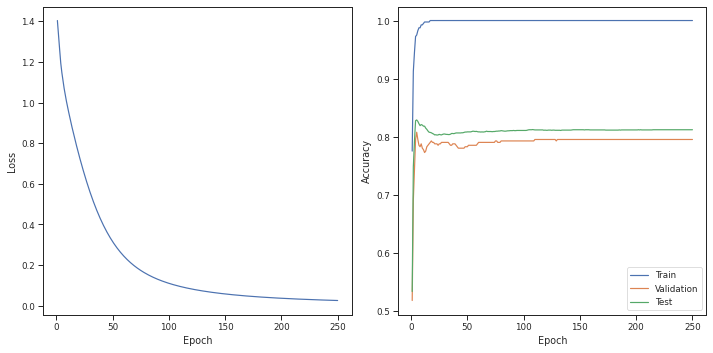

In [ ]:
model = gcn(hidden_channels=64, num_gcn=2, num_lin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epoch_plot(model, optimizer, max_epoch=250, save="gcn_epoch.png")

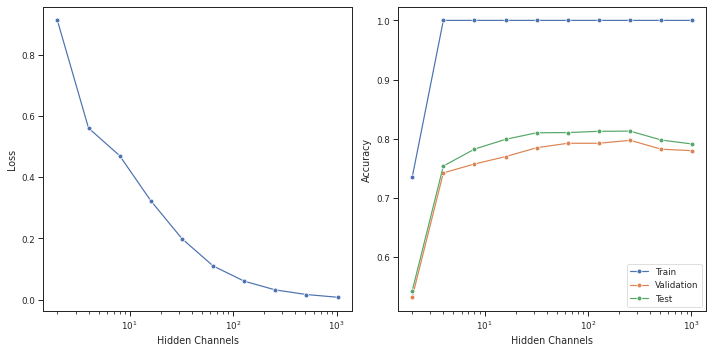

,Hidden Channels,Loss,Train,Validation,Test
0,2,0.9125,0.735,0.5325,0.5431
1,4,0.5606,1.000,0.7425,0.7541
2,8,0.4704,1.000,0.7575,0.7826
3,16,0.3232,1.000,0.7700,0.7992
4,32,0.1995,1.000,0.7850,0.8103
5,64,0.1104,1.000,0.7925,0.8106
6,128,0.0605,1.000,0.7925,0.8127
7,256,0.0320,1.000,0.7975,0.8130
8,512,0.0169,1.000,0.7825,0.7980
9,1024,0.0080,1.000,0.7800,0.7912


In [ ]:
def gcn_hidden_plot(hiddens, max_epoch=100, save="gcn_hidden.png"):
    data = []
    for hid in hiddens:
        model = gcn(hidden_channels=hid, num_gcn=2, num_lin=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        values = []
        for epo in range(max_epoch):
            loss = train(model, optimizer)
            accs = test(model)
            values.append([epo+1, loss, *accs])
        data.append([hid, *values[-1][1:]])
    df = pd.DataFrame(data, columns=["Hidden Channels", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="Hidden Channels", y="Loss", marker="o", ax=ax[0])
    sns.lineplot(data=df, x="Hidden Channels", y="Train", label="Train", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="Hidden Channels", y="Validation", label="Validation", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="Hidden Channels", y="Test", label="Test", marker="o", ax=ax[1])
    ax[0].set(xscale="log")
    ax[1].set(ylabel="Accuracy", xscale="log")
    fig.savefig(save)
    plt.show()
    return df.round(4).head(None)


gcn_hidden_plot([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])

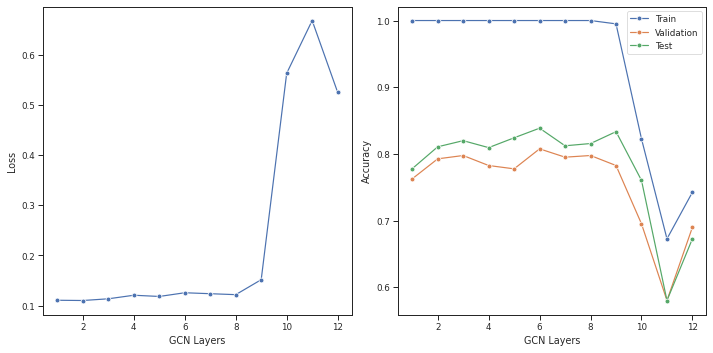

,GCN Layers,Loss,Train,Validation,Test
0,1,0.1109,1.0000,0.7625,0.7777
1,2,0.1104,1.0000,0.7925,0.8106
2,3,0.1138,1.0000,0.7975,0.8198
3,4,0.1209,1.0000,0.7825,0.8093
4,5,0.1185,1.0000,0.7775,0.8241
5,6,0.1258,1.0000,0.8075,0.8385
6,7,0.1239,1.0000,0.7950,0.8121
7,8,0.1220,1.0000,0.7975,0.8155
8,9,0.1518,0.9950,0.7825,0.8333
9,10,0.5627,0.8225,0.6950,0.7602


In [ ]:
def gcn_num_plot(gcn_nums, max_epoch=100, save="gcn_nums.png"):
    data = []
    for gnum in gcn_nums:
        model = gcn(hidden_channels=64, num_gcn=gnum, num_lin=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        values = []
        for epo in range(max_epoch):
            loss = train(model, optimizer)
            accs = test(model)
            values.append([epo+1, loss, *accs])
        data.append([gnum, *values[-1][1:]])
    df = pd.DataFrame(data, columns=["GCN Layers", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="GCN Layers", y="Loss", marker="o", ax=ax[0])
    sns.lineplot(data=df, x="GCN Layers", y="Train", label="Train", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="GCN Layers", y="Validation", label="Validation", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="GCN Layers", y="Test", label="Test", marker="o", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()
    return df.round(4).head(None)


gcn_num_plot(range(1, 13))  

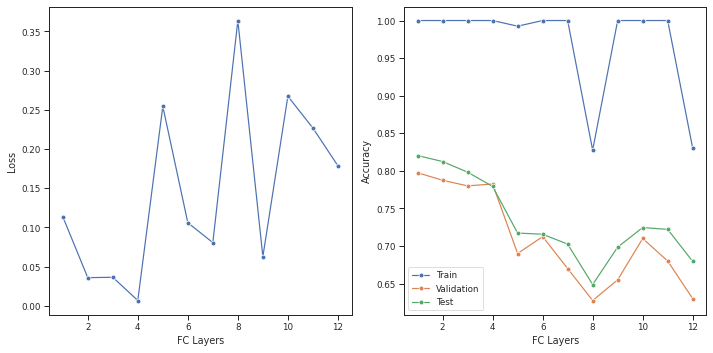

,FC Layers,Loss,Train,Validation,Test
0,1,0.1138,1.0000,0.7975,0.8204
1,2,0.0359,1.0000,0.7875,0.8124
2,3,0.0364,1.0000,0.7800,0.7983
3,4,0.0068,1.0000,0.7825,0.7792
4,5,0.2545,0.9925,0.6900,0.7172
5,6,0.1060,1.0000,0.7125,0.7157
6,7,0.0806,1.0000,0.6700,0.7025
7,8,0.3639,0.8275,0.6275,0.6488
8,9,0.0627,1.0000,0.6550,0.6985
9,10,0.2674,1.0000,0.7100,0.7246


In [ ]:
def gcn_lin_plot(lin_nums, max_epoch=100, save="gcn_lin.png"):
    data = []
    for lnum in lin_nums:
        model = gcn(hidden_channels=64, num_gcn=3, num_lin=lnum)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        values = []
        for epo in range(max_epoch):
            loss = train(model, optimizer)
            accs = test(model)
            values.append([epo+1, loss, *accs])
        data.append([lnum, *values[-1][1:]])
    df = pd.DataFrame(data, columns=["FC Layers", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="FC Layers", y="Loss", marker="o", ax=ax[0])
    sns.lineplot(data=df, x="FC Layers", y="Train", label="Train", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="FC Layers", y="Validation", label="Validation", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="FC Layers", y="Test", label="Test", marker="o", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()
    return df.round(4).head(None)


gcn_lin_plot(range(1, 13))

In [30]:
model = gcn(hidden_channels=64, num_gcn=3, num_lin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print("GCN:")
eval(model, optimizer, max_epoch=100)

GCN:
Accuracy: 0.8204
Computation Time: 14.5502s


In [55]:
# Part b, GAT

def gat(hidden_channels=64, heads=1):
    torch.manual_seed(1234567)
    layers = [
        (GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATConv((-1, -1), num_classes, heads=heads, add_self_loops=False), 'x, edge_index -> x')
    ]
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model

def gat_sub(hidden_channels=64, heads=2):
    torch.manual_seed(1234567)
    layers = [
        (GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False, return_attention_weights=True), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False, return_attention_weights=True), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATConv((-1, -1), num_classes, heads=heads, add_self_loops=False, return_attention_weights=True), 'x, edge_index -> x'),
        (Linear(heads * num_classes, num_classes), 'x -> x'),
    ]
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model

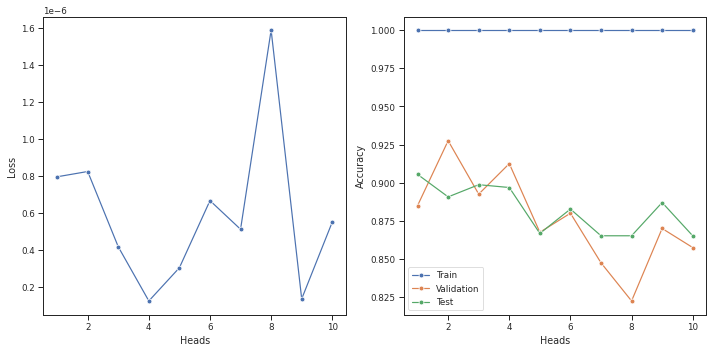

,Heads,Loss,Train,Validation,Test
0,1,0.0,1.0,0.8850,0.9054
1,2,0.0,1.0,0.9275,0.8907
2,3,0.0,1.0,0.8925,0.8987
3,4,0.0,1.0,0.9125,0.8968
4,5,0.0,1.0,0.8675,0.8667
5,6,0.0,1.0,0.8800,0.8827
6,7,0.0,1.0,0.8475,0.8652
7,8,0.0,1.0,0.8225,0.8652
8,9,0.0,1.0,0.8700,0.8870
9,10,0.0,1.0,0.8575,0.8652


In [41]:
def gat_head_plot(head_nums, max_epoch=100, save="gat_head.png"):
    data = []
    for i in head_nums:
        model = gat(heads=i)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        values = []
        for epo in range(max_epoch):
            loss = train(model, optimizer)
            accs = test(model)
            values.append([epo+1, loss, *accs])
        data.append([i, *values[-1][1:]])
    df = pd.DataFrame(data, columns=["Heads", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="Heads", y="Loss", marker="o", ax=ax[0])
    sns.lineplot(data=df, x="Heads", y="Train", label="Train", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="Heads", y="Validation", label="Validation", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="Heads", y="Test", label="Test", marker="o", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()
    return df.round(4).head(None)


gat_head_plot(range(1, 11))

In [57]:
model = gat(hidden_channels=64, heads=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print("GAT:")
eval(model, optimizer, max_epoch=100)

GAT:
Accuracy: 0.8907
Computation Time: 12.7384s


In [56]:
model = gat_sub(hidden_channels=64, heads=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("GAT using learnable coefficient:")
eval(model, optimizer, max_epoch=100)

GAT using learnable coefficient:
Accuracy: 0.9116
Computation Time: 12.6774s


In [58]:
class GATv2(GATv2Conv):
    def __init__(self, *args, **kwargs):
        self.operator = kwargs.pop("operator")
        super().__init__(*args, **kwargs)

    def message(self, x_j, x_i, edge_attr, index, ptr, size_i):
        if self.operator == "Hadamard":
            x = x_i * x_j
        elif self.operator == "Min":
            x = torch.minimum(x_i, x_j)
        elif self.operator == "Max":
            x = torch.maximum(x_i, x_j)
        else:
            x = x_i + x_j
        x = F.leaky_relu(x, self.negative_slope)
        alpha = (x * self.att).sum(dim=-1)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)


def gatv2(hidden_channels=64, heads=2, operator="Hadamard"):
    torch.manual_seed(1234567)
    layers = [
        (GATv2((-1, -1), hidden_channels, heads=heads, add_self_loops=False, operator=operator), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATv2((-1, -1), hidden_channels, heads=heads, add_self_loops=False, operator=operator), 'x, edge_index -> x'),
        ReLU(inplace=True),        
        (GATv2((-1, -1), num_classes, heads=heads, add_self_loops=False, operator=operator), 'x, edge_index -> x')
    ]
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model


In [59]:
model = gatv2(operator="Hadamard")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("GATv2 using Hadamard:")
eval(model, optimizer, max_epoch=100)

GATv2 using Hadamard:
Accuracy: 0.9143
Computation Time: 15.5159s


In [60]:
model = gatv2(operator="Min")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("GATv2 using Min:")
eval(model, optimizer, max_epoch=100)

GATv2 using Min:
Accuracy: 0.9183
Computation Time: 17.0286s


In [61]:
model = gatv2(operator="Max")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("GATv2 using Max:")
eval(model, optimizer, max_epoch=100)

GATv2 using Max:
Accuracy: 0.9245
Computation Time: 17.0818s
